In [1]:
%load_ext autoreload
%autoreload 2

test_path = "../Datasets/Padchest_Landmarks/Images"

In [2]:
import sys 
sys.path.append('..')

In [3]:
from models.hybrid import Hybrid as Hybrid
from models.hybridSkip import Hybrid as Skip
from models.hybridDoubleSkip import Hybrid as DoubleSkip

import os 

import torch
from torchvision import transforms
import numpy as np

import pathlib
import re

from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from sklearn.metrics import mean_squared_error
import scipy.sparse as sp
from utils.utils import scipy_to_torch_sparse, genMatrixesLH

def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

device = 'cuda:0'

In [4]:
A, AD, D, U = genMatrixesLH()

A = sp.csc_matrix(A).tocoo()
AD = sp.csc_matrix(AD).tocoo()
D = sp.csc_matrix(D).tocoo()
U = sp.csc_matrix(U).tocoo()

D_ = [D.copy()]
U_ = [U.copy()]
A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]

config = {}
config['n_nodes'] = [120, 120, 120, 60, 60, 60]

A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

config['latents'] = 64
config['inputsize'] = [1024, 1024]

f = 32
config['filters'] = [2, f, f, f, f//2, f//2, f//2]
config['skip_features'] = f

config['window'] = (3,3)

config['K'] = 6
config['l1'] = 6
config['l2'] = 5

double65 = DoubleSkip(config.copy(), D_t, U_t, A_t).to(device)
# double65.load_state_dict(torch.load("../weights_extended/double_65_ext/bestMSE.pt"))
double65.load_state_dict(torch.load("../TrainingSave/Lung/JSRTLungDataHybridDoubleSkip500epocs/bestMSE.pt"))
double65.eval()
print('Model loaded')

[32, 32]
6-5
Model loaded


In [5]:
from models.unet import UNet

unet = UNet(n_classes = 3).to(device)
unet.load_state_dict(torch.load('../TrainingSave/Lung/Unetlungs500epochs/bestDice_0.pt'))

unet.eval()

print('Model loaded')

Model loaded


In [6]:
data_root = pathlib.Path(test_path)
all_files = list(data_root.glob('*.png'))
all_files = [str(path) for path in all_files]
all_files.sort(key = natural_key)

In [7]:
from medpy.metric import dc, hd, assd, jc
from utils.fun import reverseVector, drawBinary
import matplotlib.pyplot as plt


def evalImageMetrics(blank, output, target):
    p1, p2, h, c1, c2 = reverseVector(output)
    
    t_lungs = np.logical_or(target == 1, target == 2)

    ptest = drawBinary(blank.copy(), p1)
    ptest = drawBinary(ptest, p2)
    # Plot ptest and target for comparison
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(ptest, cmap='gray')
    # plt.title('ptest')
    # plt.subplot(1, 2, 2)
    # plt.imshow(t_lungs, cmap='gray')
    # plt.title('target')
    # plt.show()
    
    hdp = hd(ptest, t_lungs)
    dcp = dc(ptest, t_lungs)
    ptest = drawBinary(blank.copy(), h)
    # Plot ptest and target for comparison
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(ptest, cmap='gray')
    # plt.title('ptest')
    # plt.subplot(1, 2, 2)
    # plt.imshow(target == 3, cmap='gray')
    # plt.title('target')
    # plt.show()
    

    hdc = hd(ptest, target == 3)
    dcc = dc(ptest, target == 3)

    return [dcp, hdp, dcc, hdc]

def evalImageMetricsUNet(output, target):
    t_lungs = np.logical_or(target == 1, target == 2)
    dcp = dc(output == 1, t_lungs)
    dcc = dc(output == 2, target == 3)
    
    hdp = hd(output == 1, t_lungs)
    hdc = hd(output == 2, target == 3)
    
    return [dcp, hdp, dcc, hdc]

In [8]:
from utils.fun import drawOrgans
import cv2
import numpy as np
import pandas as pd

results = pd.DataFrame()
blank = np.zeros([1024, 1024])

i = 0
for sample in all_files:
    # print(sample)
    with torch.no_grad():
        img = cv2.imread(sample, 0) / 255
        data = np.expand_dims(img, axis = 0)
        data = np.expand_dims(data, axis = 0)
        data = torch.tensor(data).to(device).float()
        
        # gt_file = sample.replace('Images','Masks')
        # print("GT file:", gt_file)
        gt = cv2.imread(sample.replace('Images','Masks'), cv2.IMREAD_UNCHANGED)


        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]

        metrics = evalImageMetrics(blank, output * 1024, gt)
             
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['HybridGNet 2-IGSC'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        
        output = unet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        
        metrics = evalImageMetricsUNet(output, gt)
        
        aux = pd.DataFrame([['UNet'] + metrics[:2] + ['Lungs']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)
        aux = pd.DataFrame([['UNet'] + metrics[2:] + ['Heart']], columns=['Model', 'Dice', 'HD', 'Organ'])
        results = results.append(aux, ignore_index = True)

        i = i+1

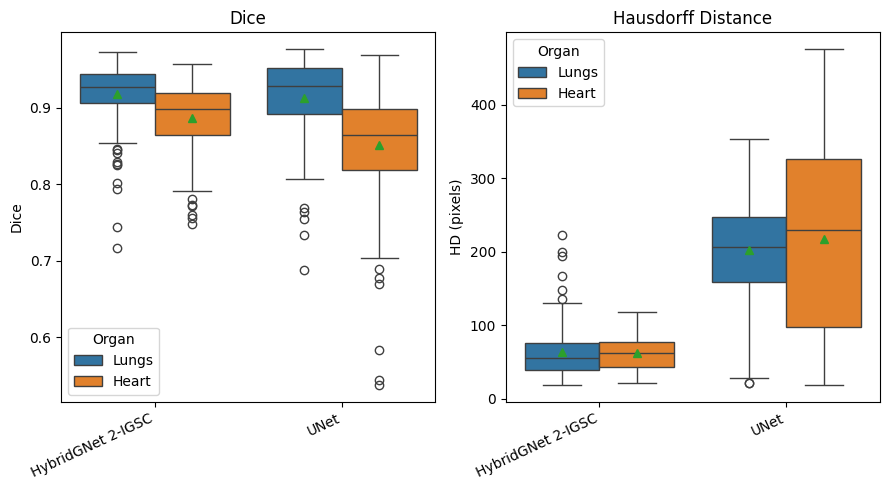

In [9]:
import seaborn as sns

plt.figure(figsize = (9,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Model', y = 'Dice', data = results, hue = 'Organ', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Model', y = 'HD', data = results, hue = 'Organ', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (pixels)')
plt.title('Hausdorff Distance')
plt.xlabel(None)

plt.tight_layout()
plt.savefig('figs/real_oc_1.png', dpi=200, bbox_inches="tight")
plt.savefig('figs/real_oc_1.pdf', dpi=200, bbox_inches="tight")
plt.show()

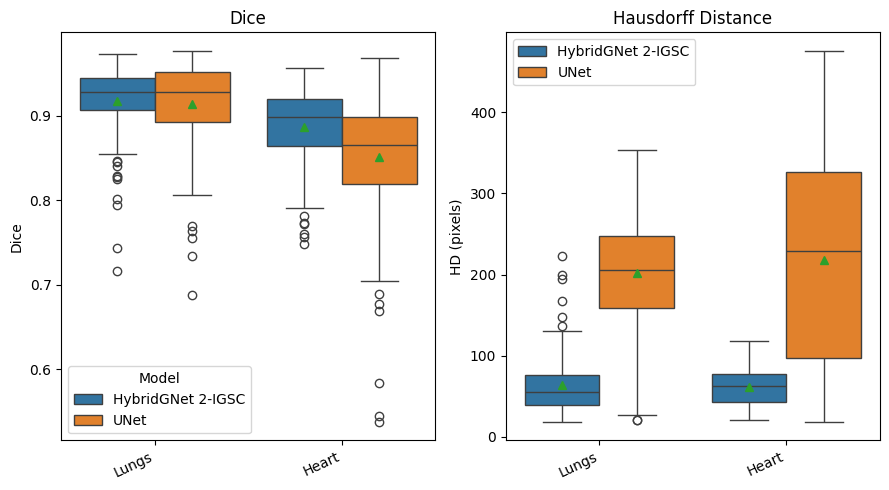

In [10]:
import seaborn as sns

plt.figure(figsize = (9,5))
plt.tight_layout()
ax = plt.subplot(1,2,1)
sns.boxplot(x = 'Organ', y = 'Dice', data = results, hue = 'Model', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('Dice')
plt.title('Dice')
plt.xlabel(None)

ax = plt.subplot(1,2,2)
sns.boxplot(x = 'Organ', y = 'HD', data = results, hue = 'Model', showmeans = True)
plt.xticks(rotation=25, ha="right" )
plt.ylabel('HD (pixels)')
plt.title('Hausdorff Distance')
plt.legend(loc='upper left')
plt.xlabel(None)

plt.tight_layout()
plt.savefig('figs/real_oc_1_v2.png', dpi=200, bbox_inches="tight")
plt.savefig('figs/real_oc_1_v2.pdf', dpi=200, bbox_inches="tight")
plt.show()

In [11]:
from scipy.stats import wilcoxon

model1 = "HybridGNet 2-IGSC"
model2 = "UNet"

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Lungs"]['Dice']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Lungs"]['Dice']

pvalue = wilcoxon(mse1, mse2)
print('Dice Lungs: p-value:', pvalue[1])

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Heart"]['Dice']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Heart"]['Dice']

pvalue = wilcoxon(mse1, mse2)
print('Dice Heart: p-value:', pvalue[1])

model1 = "HybridGNet 2-IGSC"
model2 = "UNet"

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Lungs"]['HD']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Lungs"]['HD']

pvalue = wilcoxon(mse1, mse2)
print('HD Lungs: p-value:', pvalue[1])

mse1 = results[results['Model'] == model1]
mse1 = mse1[mse1['Organ'] == "Heart"]['HD']
mse2 = results[results['Model'] == model2]
mse2 = mse2[mse2['Organ'] == "Heart"]['HD']

pvalue = wilcoxon(mse1, mse2)
print('HD Heart: p-value:', pvalue[1])

Dice Lungs: p-value: 0.9768605844280133
Dice Heart: p-value: 8.455935095225056e-09
HD Lungs: p-value: 4.099957407821741e-24
HD Heart: p-value: 8.815329957089421e-22


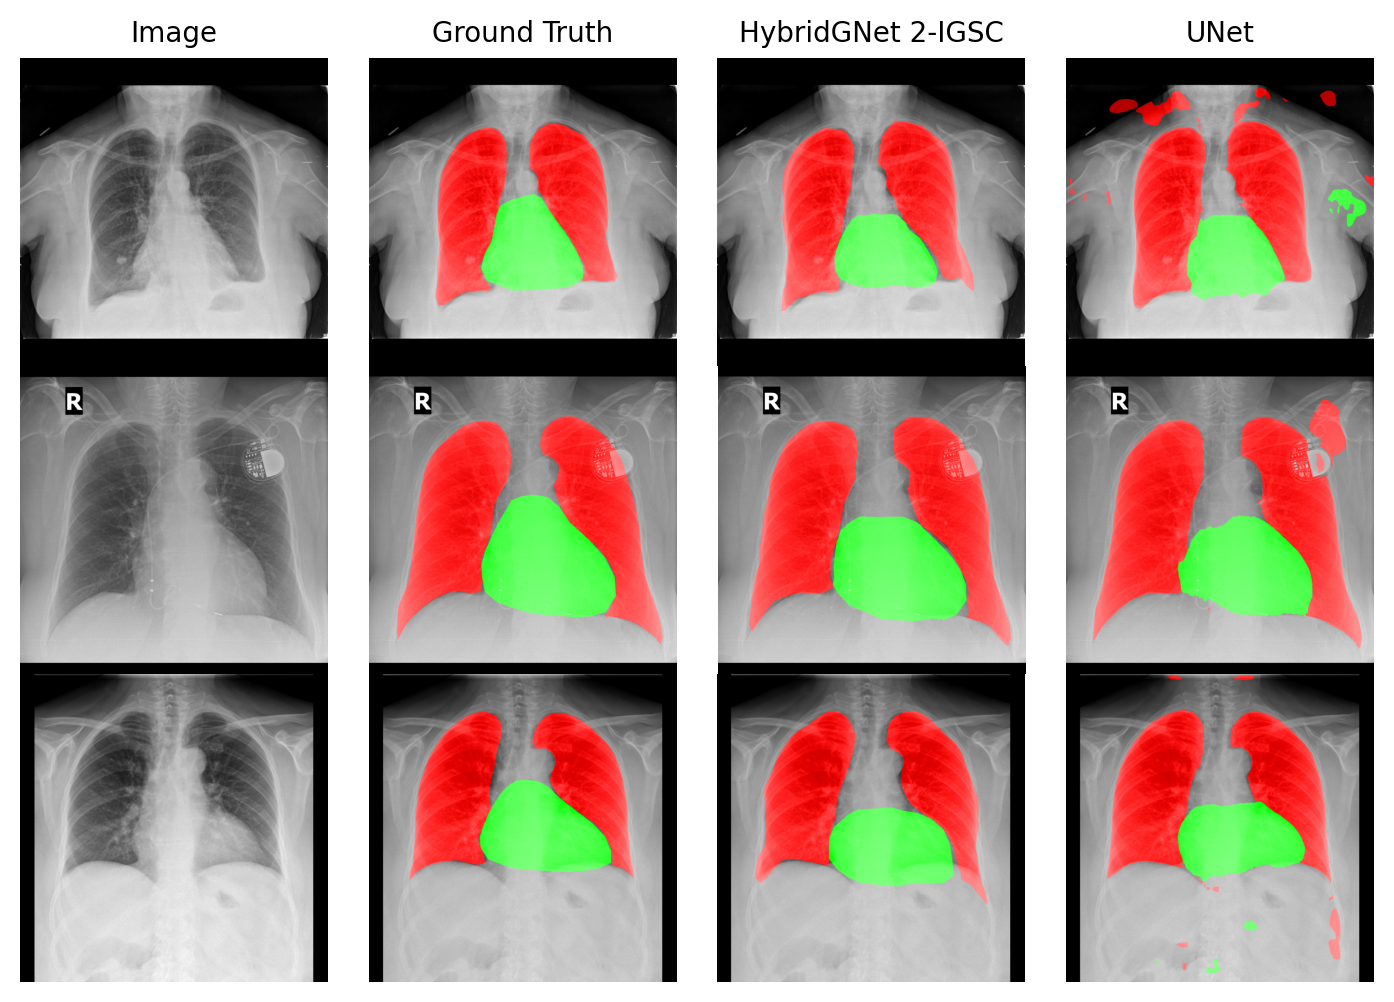

In [12]:
# indx = [1,4,8]
indx = [1,4,15]

plt.figure(figsize = (9,6), dpi = 200)

for j in range(0,3):
    sample=all_files[indx[j]]
    with torch.no_grad():
        img = cv2.imread(sample, 0) / 255
        data = np.expand_dims(img, axis = 0)
        data = np.expand_dims(data, axis = 0)
        data = torch.tensor(data).to(device).float()
        
        ax = plt.subplot(3, 4, 1 + j*4)
        plt.axis('off')
        
        if j==0:
            plt.title('Image', fontsize=10)
        plt.imshow(img, cmap = 'gray')
        
        ax = plt.subplot(3, 4, 2 + j*4)
        plt.axis('off')
        
        gt = cv2.imread(sample.replace('Images','Masks'), cv2.IMREAD_UNCHANGED)
        t_lungs = np.logical_or(gt == 1, gt == 2)

        draw = img
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (t_lungs).astype('float') - 0.3 * (gt == 3).astype('float')
        image[:,:,1] = draw + 0.7 * (gt == 3).astype('float') - 0.2 * (t_lungs).astype('float')
        image[:,:,2] = draw - 0.2 * (t_lungs).astype('float') - 0.3 * (gt == 3).astype('float')
        image = np.clip(image, 0, 1)

        if j==0:
            plt.title('Ground Truth', fontsize=10)
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
        ax = plt.subplot(3, 4, 3 + j*4)
        plt.axis('off')
                         
        output = double65(data)
        if len(output) > 1:
            output = output[0]
            
        output = output.cpu().numpy().reshape(-1) 
        output = np.clip(output, 0, 1)[:240]
        
        p1, p2, h, c1, c2 = reverseVector(output * 1024)
    
        lungs = drawBinary(blank.copy(), p1) 
        lungs = drawBinary(lungs, p2) / 255
        heart = drawBinary(blank.copy(), h) / 255
        
        output = lungs + 2 * heart
        
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)

        if j==0:
            plt.title('HybridGNet 2-IGSC', fontsize=10)
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)

        ax = plt.subplot(3, 4, 4 + j*4)
        plt.axis('off')

        output = unet(data)
        output = torch.argmax(output[0,:,:,:], axis=0).cpu().numpy()
        
        image = np.zeros(list(draw.shape) + [3])
        image[:,:,0] = draw + 0.7 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image[:,:,1] = draw + 0.7 * (output == 2).astype('float') - 0.2 * (output == 1).astype('float')
        image[:,:,2] = draw - 0.2 * (output == 1).astype('float') - 0.3 * (output == 2).astype('float')
        image = np.clip(image, 0, 1)
        
        if j==0:
            plt.title('UNet', fontsize=10)
            
        plt.imshow(image)
        plt.xlim(1, 1024)
        plt.ylim(1024, 1)
        
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('figs/real_oc_2.png', bbox_inches= 'tight', dpi = 200)
# plt.savefig('figs/real_oc_2.pdf', bbox_inches= 'tight', dpi = 200)

# Setting up the data for classification or regression models. DONT run again

In [15]:
import pandas as pd

clinical = pd.read_csv('../Datasets/Padchest_Landmarks/clinicalPadJRST.csv')
clinical 



,File,Dataset,Lung Annotations,Heart Annotations,Sex,Age,Condition
0,1256842362861431725328351539259305635_u1qifz.png,Padchest,True,True,M,90,"['aortic elongation', 'vertebral degenerative ..."
1,10155709300728342918543955138521808206_f7cj92.png,Padchest,True,True,F,79,"['nodule', 'pleural effusion', 'chronic change..."
2,10287653421930576798556842610982533460_vpbhw6.png,Padchest,True,True,F,71,"['diaphragmatic eventration', 'cardiomegaly']"
3,10383960670432673238945376919735423432_hd3moq.png,Padchest,True,True,M,79,['cardiomegaly']
4,10996416492353037588312781035930080694_8rstz0.png,Padchest,True,True,F,85,"['pacemaker', 'cardiomegaly']"
...,...,...,...,...,...,...,...
378,JPCNN089.png,JSRT,True,True,M,50,non-nodule
379,JPCNN090.png,JSRT,True,True,F,68,non-nodule
380,JPCNN091.png,JSRT,True,True,M,81,non-nodule
381,JPCNN092.png,JSRT,True,True,F,70,non-nodule


In [33]:
subset = clinical[clinical['Dataset'] == "Padchest"]

count_pace = 0
count_aortic = 0
count_cardio = 0

for condition in subset['Condition']:
    if 'aortic elongation' in condition:
        count_aortic+=1
    if 'pacemaker' in condition:
        count_pace+=1
    if 'cardiomegaly' in condition:
        count_cardio+=1

print(count_pace, count_aortic, count_cardio)


15 45 137


In [34]:
subset_JSRT = clinical[clinical['Dataset'] == "JSRT"]
count_nonnodule = 0

for condition in subset_JSRT['Condition']:
    if 'non-nodule' in condition:
        count_nonnodule+=1
print(count_nonnodule)

93


In [35]:
subset_nonnodule = subset_JSRT[subset_JSRT['Condition'] == 'non-nodule']
subset_nonnodule

,File,Dataset,Lung Annotations,Heart Annotations,Sex,Age,Condition
290,JPCNN001.png,JSRT,True,True,F,30,non-nodule
291,JPCNN002.png,JSRT,True,True,M,62,non-nodule
292,JPCNN003.png,JSRT,True,True,F,70,non-nodule
293,JPCNN004.png,JSRT,True,True,M,52,non-nodule
294,JPCNN005.png,JSRT,True,True,M,25,non-nodule
...,...,...,...,...,...,...,...
378,JPCNN089.png,JSRT,True,True,M,50,non-nodule
379,JPCNN090.png,JSRT,True,True,F,68,non-nodule
380,JPCNN091.png,JSRT,True,True,M,81,non-nodule
381,JPCNN092.png,JSRT,True,True,F,70,non-nodule


In [51]:
# take 50 images from each dataset

subset_nonnodule50 = subset_nonnodule.sample(50)
subset50 = subset.sample(50)
count_pace = 0
count_aortic = 0
count_cardio = 0
count_nonnodule = 0

new_subset = pd.concat([subset50, subset_nonnodule50])

for condition in new_subset['Condition']:
    if 'aortic elongation' in condition:
        count_aortic+=1
    if 'pacemaker' in condition:
        count_pace+=1
    if 'cardiomegaly' in condition:
        count_cardio+=1
    if 'non-nodule' in condition:
        count_nonnodule+=1

print(count_pace, count_aortic, count_cardio, count_nonnodule)

6 14 50 50


In [52]:
new_subset


,File,Dataset,Lung Annotations,Heart Annotations,Sex,Age,Condition
54,120641250378848817226599591125249193787_1vwu72...,Padchest,True,True,M,85,"['scoliosis', 'COPD signs', 'cardiomegaly', 'k..."
90,175993948212683701562003497511214331387_sr16co...,Padchest,True,True,M,66,"['kyphosis', 'COPD signs', 'cardiomegaly']"
89,174670802714657222439280962872741263127_7fupbg...,Padchest,True,True,F,71,"['aortic elongation', 'chronic changes', 'call..."
120,282084762366059076387208905274707563447_d4ptrb...,Padchest,True,True,M,76,"['COPD signs', 'pacemaker', 'cardiomegaly']"
20,47557396307760215809300057577936592627_m7mq32.png,Padchest,True,True,M,76,"['infiltrates', 'pacemaker', 'cardiomegaly']"
...,...,...,...,...,...,...,...
368,JPCNN079.png,JSRT,True,True,M,72,non-nodule
351,JPCNN062.png,JSRT,True,True,F,89,non-nodule
356,JPCNN067.png,JSRT,True,True,F,59,non-nodule
361,JPCNN072.png,JSRT,True,True,M,34,non-nodule


In [53]:
import shutil

JSRT_Imaget_src_dir_test = '../Datasets/JSRT/Test/Images'
JSRT_Images_dst_dir_test = '../Datasets/PadJSRTClassification/Images'
JSRT_Landmarks_src_dir_test = '../Datasets/JSRT/Test/landmarks'
JSRT_Lanmarks_dst_dir_test= '../Datasets/PadJSRTClassification/Landmarks'

JSRT_Imaget_src_dir_train = '../Datasets/JSRT/Train/Images'
JSRT_Images_dst_dir_train = '../Datasets/PadJSRTClassification/Images'
JSRT_Landmarks_src_dir_train = '../Datasets/JSRT/Train/landmarks'
JSRT_Lanmarks_dst_dir_train= '../Datasets/PadJSRTClassification/Landmarks'

JSRT_Imaget_src_dir_val = '../Datasets/JSRT/Val/Images'
JSRT_Images_dst_dir_val = '../Datasets/PadJSRTClassification/Images'
JSRT_Landmarks_src_dir_val = '../Datasets/JSRT/Val/landmarks'
JSRT_Lanmarks_dst_dir_val= '../Datasets/PadJSRTClassification/Landmarks'

Pad_Imaget_src_dir = '../Datasets/Padchest_Landmarks/Images'
Pad_Images_dst_dir = '../Datasets/PadJSRTClassification/Images'

Pad_Landmarks_src_dir_H = '../Datasets/Padchest_Landmarks/landmarks/H'
Pad_Landmarks_dst_dir_H = '../Datasets/PadJSRTClassification/landmarks/H'
Pad_Landmarks_src_dir_LL = '../Datasets/Padchest_Landmarks/landmarks/LL'
Pad_Landmarks_dst_dir_LL = '../Datasets/PadJSRTClassification/landmarks/LL'
Pad_Landmarks_src_dir_RL = '../Datasets/Padchest_Landmarks/landmarks/RL'
Pad_Landmarks_dst_dir_RL = '../Datasets/PadJSRTClassification/landmarks/RL'

Pad_masks_src_dir = '../Datasets/Padchest_Landmarks/Masks'
Pad_masks_dst_dir = '../Datasets/PadJSRTClassification/Masks'
# scr_dir = [JSRT_Imaget_src_dir_test, JSRT_Landmarks_src_dir_test, JSRT_Imaget_src_dir_train, JSRT_Landmarks_src_dir_train, JSRT_Imaget_src_dir_val, JSRT_Landmarks_src_dir_val, Pad_Imaget_src_dir, Pad_Landmarks_src_dir, Pad_masks_src_dir]
# dst_dir = [JSRT_Images_dst_dir_test, JSRT_Lanmarks_dst_dir_test, JSRT_Images_dst_dir_train, JSRT_Lanmarks_dst_dir_train, JSRT_Images_dst_dir_val, JSRT_Lanmarks_dst_dir_val, Pad_Images_dst_dir, Pad_Landmarks_dst_dir, Pad_masks_dst_dir]


In [54]:
src_dirs = [JSRT_Imaget_src_dir_test, JSRT_Landmarks_src_dir_test, JSRT_Imaget_src_dir_train, JSRT_Landmarks_src_dir_train, JSRT_Imaget_src_dir_val, JSRT_Landmarks_src_dir_val, Pad_Imaget_src_dir, Pad_Landmarks_src_dir_H, Pad_Landmarks_src_dir_LL,Pad_Landmarks_src_dir_RL, Pad_masks_src_dir]
dst_dirs = [JSRT_Images_dst_dir_test, JSRT_Lanmarks_dst_dir_test, JSRT_Images_dst_dir_train, JSRT_Lanmarks_dst_dir_train, JSRT_Images_dst_dir_val, JSRT_Lanmarks_dst_dir_val, Pad_Images_dst_dir, Pad_Landmarks_dst_dir_H, Pad_Landmarks_dst_dir_LL, Pad_Landmarks_dst_dir_RL, Pad_masks_dst_dir]
print(src_dirs.__len__())
print(dst_dirs.__len__())


11
11


In [55]:
# import os.path

# # Loop over the source and destination directories
# for src_dir, dst_dir in zip(src_dirs, dst_dirs):
#     # Create the destination directory if it doesn't exist
#     os.makedirs(dst_dir, exist_ok=True)
    
#     # Get a list of all files in the source directory
#     files = os.listdir(src_dir)
    
#     # Copy each file to the destination directory
#     for file in files:
#         # Remove the file extension
#         file_without_ext, ext = os.path.splitext(file)
        
#         # Construct the corresponding .png file name
#         png_file = file_without_ext + '.png'
        
#         if png_file in new_subset['File'].values and ext in ['.png', '.npy']:
#             shutil.copy(os.path.join(src_dir, file), dst_dir)

In [56]:
# replace png with npy in csv subset
new_subset['File'] = new_subset['File'].str.replace('.png', '.npy')

C:\Users\marie\AppData\Local\Temp\ipykernel_16612\3214392784.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  new_subset['File'] = new_subset['File'].str.replace('.png', '.npy')


In [57]:
from sklearn.model_selection import train_test_split
import pathlib

# Define the indices for splitting the combined landmarks
right_lung_indices = slice(0, 44)
left_lung_indices = slice(44, 94)
heart_indices = slice(94, 120)

jrst_landmarks = '../Datasets/PadJSRTClassification/Landmarks'
Pad_h = "../Datasets/PadJSRTClassification/H"
Pad_ll = "../Datasets/PadJSRTClassification/LL"
Pad_rl = "../Datasets/PadJSRTClassification/RL"



# combine Padchest lungs and hearts landmarks

for i in range(50):
    rl = np.load(os.path.join(Pad_rl, new_subset.iloc[i]['File']))
    ll = np.load(os.path.join(Pad_ll, new_subset.iloc[i]['File']))
    h = np.load(os.path.join(Pad_h, new_subset.iloc[i]['File']))
    landmarks = np.concatenate([h, ll, rl])
    np.save(os.path.join(jrst_landmarks, new_subset.iloc[i]['File']), landmarks)

print(h.shape[0])
print(ll.shape[0])
print(rl.shape[0])

print(landmarks.shape[0])




26
50
44
120


In [58]:
# Split the dataset into training and test sets
train, test = train_test_split(new_subset, test_size=0.30, random_state=42)
test, val = train_test_split(test, test_size=0.50, random_state=42)

# train['File'] = train['File'].str.replace('.npy', '.png')
# test['File'] = test['File'].str.replace('.npy', '.png')
# val['File'] = val['File'].str.replace('.npy', '.png')

test

,File,Dataset,Lung Annotations,Heart Annotations,Sex,Age,Condition
4,10996416492353037588312781035930080694_8rstz0.npy,Padchest,True,True,F,85,"['pacemaker', 'cardiomegaly']"
332,JPCNN043.npy,JSRT,True,True,F,52,non-nodule
300,JPCNN011.npy,JSRT,True,True,M,61,non-nodule
53,119688533980562249677219589534851011987_60uvre...,Padchest,True,True,F,85,"['vascular redistribution', 'vertebral degener..."
73,146381384591357414868726401545939282660_96eirs...,Padchest,True,True,M,71,"['aortic elongation', 'cardiomegaly']"
378,JPCNN089.npy,JSRT,True,True,M,50,non-nodule
1,10155709300728342918543955138521808206_f7cj92.npy,Padchest,True,True,F,79,"['nodule', 'pleural effusion', 'chronic change..."
3,10383960670432673238945376919735423432_hd3moq.npy,Padchest,True,True,M,79,['cardiomegaly']
360,JPCNN071.npy,JSRT,True,True,F,84,non-nodule
305,JPCNN016.npy,JSRT,True,True,M,49,non-nodule


In [59]:
for file in train['File']:
    shutil.copy(os.path.join(jrst_landmarks, file), os.path.join('../Datasets/PadJSRTClassification/Train/Landmarks', file))
    shutil.copy(os.path.join(Pad_Images_dst_dir, file.replace('.npy', '.png')), os.path.join('../Datasets/PadJSRTClassification/Train/Images', file.replace('.npy', '.png')))

for file in test['File']:
    shutil.copy(os.path.join(jrst_landmarks, file), os.path.join('../Datasets/PadJSRTClassification/Test/Landmarks', file))
    shutil.copy(os.path.join(Pad_Images_dst_dir, file.replace('.npy', '.png')), os.path.join('../Datasets/PadJSRTClassification/Test/Images', file.replace('.npy', '.png')))

for file in val['File']:  
    shutil.copy(os.path.join(jrst_landmarks, file), os.path.join('../Datasets/PadJSRTClassification/Val/Landmarks', file))
    shutil.copy(os.path.join(Pad_Images_dst_dir, file.replace('.npy', '.png')), os.path.join('../Datasets/PadJSRTClassification/Val/Images', file.replace('.npy', '.png')))

In [60]:
#Save csv file for the new dataset
train.to_csv('../Datasets/PadJSRTClassification/train.csv', index = False)
test.to_csv('../Datasets/PadJSRTClassification/test.csv', index = False)
val.to_csv('../Datasets/PadJSRTClassification/val.csv', index = False)

# CLassification or regression Code test

In [61]:
from utils.dataLoader import LandmarksDataset, ToTensor, Rescale
from torch.utils.data import DataLoader

train_path = "../Datasets/PadJSRTClassification/Train"
test_path = "../Datasets/PadJSRTClassification/Test"
val_path = "../Datasets/PadJSRTClassification/Val"

img_path = os.path.join(test_path, 'Images')
label_path = os.path.join(test_path, 'landmarks')
test_dataset = LandmarksDataset(img_path=img_path,
                                 label_path=label_path,
                                 transform = transforms.Compose([
                                             Rescale([1024,1024]),
                                             ToTensor()])
                                 )

img_path1 = os.path.join(train_path, 'Images')
label_path1 = os.path.join(train_path, 'landmarks')
train_dataset = LandmarksDataset(img_path=img_path1,
                                 label_path=label_path1,
                                 transform = transforms.Compose([
                                             Rescale([1024,1024]),
                                             ToTensor()])
                                 )

img_path2 = os.path.join(val_path, 'Images')
label_path2 = os.path.join(val_path, 'landmarks')
Val_dataset = LandmarksDataset(img_path=img_path2,
                                 label_path=label_path2,
                                 transform = transforms.Compose([
                                             Rescale([1024,1024]),
                                             ToTensor()])
                                 )
print(len(train_dataset))
print(len(test_dataset))
print(len(Val_dataset))


70
15
15


In [62]:
def extract_features(df, dataset):
    features = []
    df = df.sort_values('File')

    labels = df['Condition'].values
    labels = [1 if 'cardiomegaly' in label else 0 for label in labels]

    for i in range(len(dataset)):
        features.append(dataset[i]['landmarks'][:120])
    return torch.stack(features), torch.tensor(labels)

train = pd.read_csv('../Datasets/PadJSRTClassification/train.csv')
test = pd.read_csv('../Datasets/PadJSRTClassification/test.csv')
val = pd.read_csv('../Datasets/PadJSRTClassification/val.csv')

# Extract features from the datasets
train_features, train_labels = extract_features(train, train_dataset)
test_features, test_labels = extract_features(test, test_dataset)
val_features, val_labels = extract_features(val, Val_dataset)

# Convert features to numpy arrays for compatibility with scikit-learn
train_features = train_features.numpy()
test_features = test_features.numpy()
val_features = val_features.numpy()
print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)
print("val_features shape:", val_features.shape)

train_lungs_features = train_features[:, :94]
test_lungs_features = test_features[:, :94]
val_lungs_features = val_features[:, :94]

train_heart_features = train_features[:, 94:]
test_heart_features = test_features[:, 94:]
val_heart_features = val_features[:, 94:]
print("train_eyes_features shape:", train_lungs_features.shape)
print("test_eyes_features shape:", test_lungs_features.shape)
print("val_eyes_features shape:", val_lungs_features.shape)
print("train_mouth_features shape:", train_heart_features.shape)
print("test_mouth_features shape:", test_heart_features.shape)
print("val_mouth_features shape:", val_heart_features.shape)


# Reshape the features
train_features = train_features.reshape(70, -1)
test_features = test_features.reshape(15, -1)
val_features = val_features.reshape(15, -1)

train_eyes_features = train_lungs_features.reshape(70, -1)
test_eyes_features = test_lungs_features.reshape(15, -1)
val_eyes_features = val_lungs_features.reshape(15, -1)

train_mouth_features = train_heart_features.reshape(70, -1)
test_mouth_features = test_heart_features.reshape(15, -1)
val_mouth_features = val_heart_features.reshape(15, -1)


print("train_features shape:", train_features.shape)
print("test_features shape:", test_features.shape)
print("val_features shape:", val_features.shape)
print("train_eyes_features shape:", train_eyes_features.shape)
print("test_eyes_features shape:", test_eyes_features.shape)
print("val_eyes_features shape:", val_eyes_features.shape)
print("train_mouth_features shape:", train_mouth_features.shape)
print("test_mouth_features shape:", test_mouth_features.shape)
print("val_mouth_features shape:", val_mouth_features.shape)

train_features shape: (70, 120, 2)
test_features shape: (15, 120, 2)
val_features shape: (15, 120, 2)
train_eyes_features shape: (70, 94, 2)
test_eyes_features shape: (15, 94, 2)
val_eyes_features shape: (15, 94, 2)
train_mouth_features shape: (70, 26, 2)
test_mouth_features shape: (15, 26, 2)
val_mouth_features shape: (15, 26, 2)
train_features shape: (70, 240)
test_features shape: (15, 240)
val_features shape: (15, 240)
train_eyes_features shape: (70, 188)
test_eyes_features shape: (15, 188)
val_eyes_features shape: (15, 188)
train_mouth_features shape: (70, 52)
test_mouth_features shape: (15, 52)
val_mouth_features shape: (15, 52)


In [63]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import tree

model1 = SVC()
model2 = tree.DecisionTreeClassifier()
model1.fit(train_features, train_labels)
model2.fit(train_features, train_labels)



DecisionTreeClassifier()

In [68]:
# Make predictions on the test set
y_test_pred = model2.predict(test_features)


# Evaluate the model on the test set
print("Test Accuracy:", accuracy_score(test_labels, y_test_pred))
print("Test Classification Report:\n", classification_report(test_labels, y_test_pred))

# Predict on the validation set
y_val_pred = model2.predict(val_features)

# Evaluate the model on the validation set
print("Validation Accuracy:", accuracy_score(val_labels, y_val_pred))
print("Validation Classification Report:\n", classification_report(val_labels, y_val_pred))

# Cross-validation
cv_scores = cross_val_score(model2, train_features, train_labels, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {cv_scores.mean()}')

Test Accuracy: 1.0
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         8

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Validation Accuracy: 1.0
Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         9

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Score: 1.0


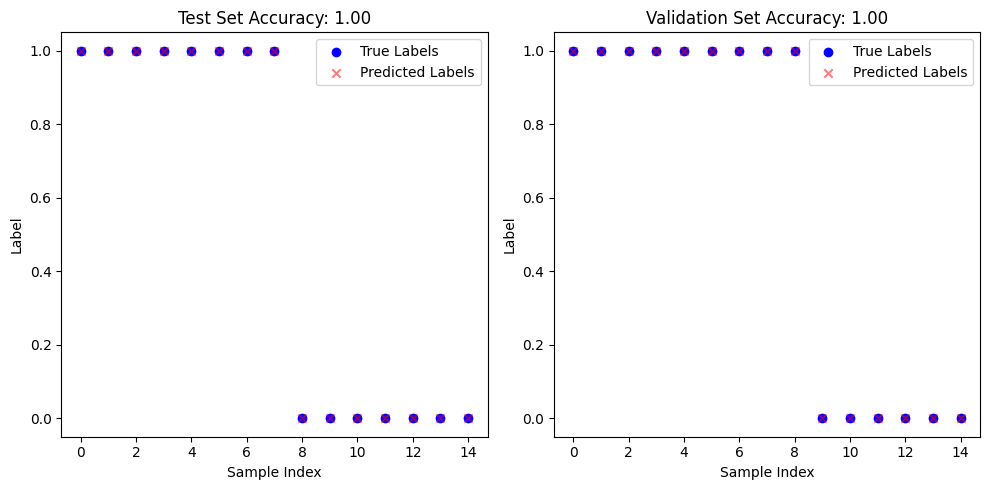

In [221]:
# Plot the results
plt.figure(figsize=(10, 5))

# Plot for test set
plt.subplot(1, 2, 1)
plt.scatter(np.arange(len(test_labels)), test_labels, color='blue', label='True Labels', marker='o')
plt.scatter(np.arange(len(test_labels)), y_test_pred, color='red', alpha=0.5, label='Predicted Labels', marker='x')
plt.title(f'Test Set Accuracy: {accuracy_score(test_labels, y_test_pred):.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()

# Plot for validation set
plt.subplot(1, 2, 2)
plt.scatter(np.arange(len(val_labels)), val_labels, color='blue', label='True Labels', marker='o')
plt.scatter(np.arange(len(val_labels)), y_val_pred, color='red', alpha=0.5, label='Predicted Labels', marker='x')
plt.title(f'Validation Set Accuracy: {accuracy_score(val_labels, y_val_pred):.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.legend()

plt.tight_layout()
plt.show()

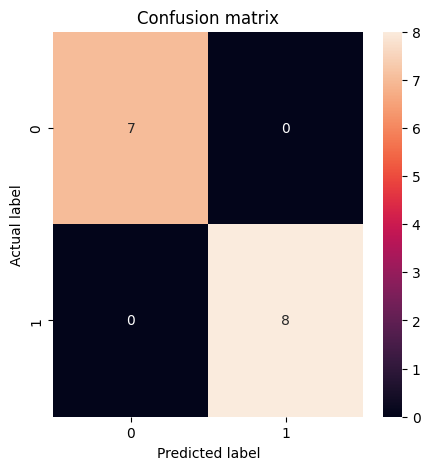

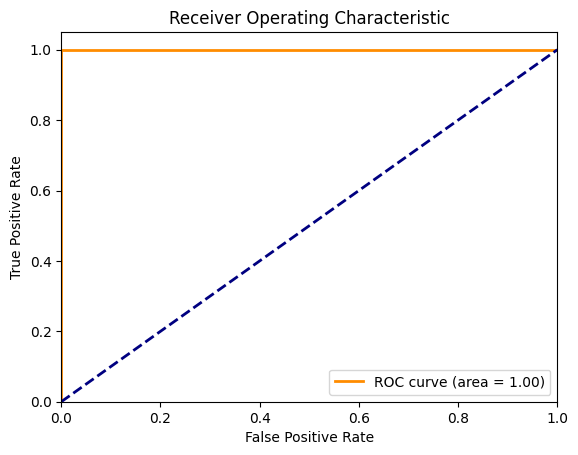

In [223]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_predictions(y_true, y_pred, y_pred_proba):
    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.show()

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Assume y_test are the true labels and y_pred are the predicted labels
# y_pred_proba are the predicted probabilities of the positive class
plot_predictions(test_labels, y_test_pred, y_test_pred_proba)